## 8. Plot change of mind trials, single cell data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting.v0 as ss

from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation,QualityMetrics)
from spyglass.spikesorting.v0.curation_figurl import CurationFigurl,CurationFigurlSelection
from spyglass.spikesorting.v0.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.spikesorting.v0.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection,IntervalLinearizedPosition

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from pprint import pprint
from spyglass.shijiegu.ripple_detection import removeDataBeforeTrial1
from spyglass.shijiegu.helpers import interpolate_to_new_time
from spyglass.shijiegu.placefield import place_field,placefield_to_peak1dloc
from spyglass.shijiegu.Analysis_SGU import DecodeResultsLinear, TetrodeNumber
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)
warnings.filterwarnings('ignore')

from spyglass.shijiegu.curation_manual import load_waveforms
from spyglass.shijiegu.placefield import place_field, placefield_to_peak1dloc, cell_by_arm

[2025-03-12 13:31:21,409][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-03-12 13:31:21,439][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [3]:
from spyglass.shijiegu.helpers import interval_union
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,ExtendedRippleTimes,RippleTimesWithDecode
from spyglass.shijiegu.load import load_run_sessions, load_decode
from spyglass.shijiegu.singleUnit import (do_mountainSort,electrode_unit,
            RippleTime2FiringRate,findWaveForms,RippleTime2Index,get_nwb_units)

from spyglass.shijiegu.load import load_theta_maze, load_theta
from spyglass.shijiegu.Analysis_SGU import get_linearization_map,segment_to_linear_range
from spyglass.shijiegu.theta import return_firing
from spyglass.shijiegu.Analysis_SGU import get_linearization_map
from spyglass.shijiegu.changeOfMind import find_trials_session_plot, find_trials, load_epoch_data_wrapper, findPlottingStartEnd, findTurnAround_t, findDirectionPlot
from scipy.stats import beta

from spyglass.shijiegu.ripple_add_replay import plot_decode_sortedSpikes, select_subset_helper, select_subset_helper_pd

[13:31:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[13:31:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [504]:
nwb_copy_file_name = 'haydn20230604_.nwb'

In [505]:
run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
haydn20230604_ 1         01_Rev3Sleep1  pos 0 valid ti
haydn20230604_ 2         02_Rev3Session pos 1 valid ti
haydn20230604_ 3         03_Rev3Sleep2  pos 2 valid ti
haydn20230604_ 4         04_Rev3Session pos 3 valid ti
haydn20230604_ 5         05_Rev3Sleep3  pos 4 valid ti
haydn20230604_ 6         06_Rev3Session pos 5 valid ti
haydn20230604_ 7         07_Rev3Sleep4  pos 6 valid ti
haydn20230604_ 8         08_Rev3Session pos 7 valid ti
haydn20230604_ 9         09_Rev3Sleep5  pos 8 valid ti
haydn20230604_ 10        10_Rev3Session pos 9 valid ti
haydn20230604_ 11        11_Rev3Sleep6  pos 10 valid t
 (Total: 11)



In [506]:
epoch_num = 1
session_name = run_session_names[epoch_num]
position_name = pos_session_names[epoch_num]
print(session_name, position_name)

04_Rev3Session2 pos 3 valid times


### 1. Do calculations and plot decode.
The function `electrode_unit` finds you nwb_units which includes spike times for all units.

In [7]:
decode_options = {}
decode_options["encoding_set"] = '2Dheadspeed_above_4'
decode_options["classifier_param_name"] = 'default_decoding_gpu_4armMaze_W40msO20ms'
decode_options["decode_threshold_method"] = 'MUA_0SD'
decode_options["causal"] = False
decode_options["likelihood"] = True

(rowID, smoothed_placefield, placefield_peak,
     spike_count_by_arm_direction, betaPdfs, means) = find_trials_session_plot(
        nwb_copy_file_name,session_name,position_name,
        proportion_threshold = 0.1, sorted = True, curation_id = 1, decode_options = decode_options)

[13:34:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times
epoch name 02_Rev2Session1
epoch_pos_name pos 1 valid times


DataJointError: fetch1 should only return one tuple. 0 tuples found

#### Now we use decoding smaller window, state space decoding. Likelihood = False

In [435]:
decode_options = {}
decode_options["encoding_set"] = '2Dheadspeed_above_4'
decode_options["classifier_param_name"] = 'default_decoding_gpu_4armMaze'
decode_options["decode_threshold_method"] = 'MUA_0SD'
decode_options["causal"] = False
decode_options["likelihood"] = False

(rowID, smoothed_placefield, placefield_peak,
     spike_count_by_arm_direction, time_spent_by_arm_direction, betaPdfs, means) = find_trials_session_plot(
        nwb_copy_file_name,session_name,position_name,
        proportion_threshold = 0.1, sorted = True, curation_id = 1, decode_options = decode_options)

[10:41:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times
epoch name 04_Seq2Session2
epoch_pos_name pos 3 valid times


DataJointError: fetch1 should only return one tuple. 0 tuples found

In [ ]:
spike_count_by_arm_direction[(0,3)]

In [ ]:
print(f"This session has {len(spike_count_by_arm_direction.keys())} neurons.")

### 2. Confirm directionality threshold.

#### For inbound direction, we use < 0.2 as a cutoff. For outbound direction, we use > 0.8 as cutoff.

In [85]:
#placefield_peak

In [ ]:
(cells, smoothed_placefield, placefield_peak,
 spike_count_by_arm_direction, time_spent_by_arm_direction, betaPdfs, means) = place_field_direction(nwb_copy_file_name,
                                                                                   session_name,position_name,
                                                                                   curation_id = 1)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10,3))

fr_ratio_by_arm = {}
(fr_ratio_by_arm[0],
 fr_ratio_by_arm[1],fr_ratio_by_arm[2],
 fr_ratio_by_arm[3],fr_ratio_by_arm[4]) = ([],[],[],[],[])

for key in time_spent_by_arm_direction.keys():
    fr = spike_count_by_arm_direction[key] / time_spent_by_arm_direction[key]
    fr_ratio = fr[0,:] / (fr[0,:] + fr[1,:])
    for a in [0,1,2,3,4]:
        fr_ratio_by_arm[a].append(fr_ratio[a])

axes[0].hist(np.concatenate([fr_ratio_by_arm[a] for a in [1,2,3,4]]),20)
axes[0].set_title("Histogram of firing rate ratio")
axes[0].set_xlabel("$ratio$ (inbound fr/(outbound fr + inbound fr))")

for key in time_spent_by_arm_direction.keys():
    fr = spike_count_by_arm_direction[key]
    fr_ratio = fr[0,:] / (fr[0,:] + fr[1,:])
    for a in [0,1,2,3,4]:
        fr_ratio_by_arm[a].append(fr_ratio[a])

axes[1].hist(np.concatenate([fr_ratio_by_arm[a] for a in [1,2,3,4]]),20)
axes[1].set_title("Histogram of spike count ratio")
axes[1].set_xlabel("$ratio$ (inbound count/(outbound count + inbound count))")


In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (15,3))

totalPdfNum = np.sum([len(betaPdfs[a]) for a in [1,2,3,4]])

x = np.linspace(0,1,100)
y = np.zeros((totalPdfNum,len(x)))

i = 0
for a in [1,2,3,4]:
    for betaPdf in betaPdfs[a]:
        y_ = betaPdf.pdf(x)
        y[i,:]= y_/np.sum(y_)
        axes[0].plot(x, y_/np.sum(y_), '-k',lw=1, alpha = 0.3, label='pdf')
        i = i + 1
        
y = np.nanmean(y, axis = 0)
axes[1].plot(x,y) 
axes[0].set_title("all beta distributions of alpha")
axes[1].set_title("average beta distributions of alpha")

axes[2].hist(np.concatenate([means[a] for a in [1,2,3,4]]),20)
axes[2].set_title("Histogram of mean of beta")

axes[0].set_xlabel("$ratio$ (inbound/outbound)")
axes[1].set_xlabel("$ratio$ (inbound/outbound)")
axes[2].set_xlabel("$ratio$ (inbound/outbound)")



### 3. Plot place field:

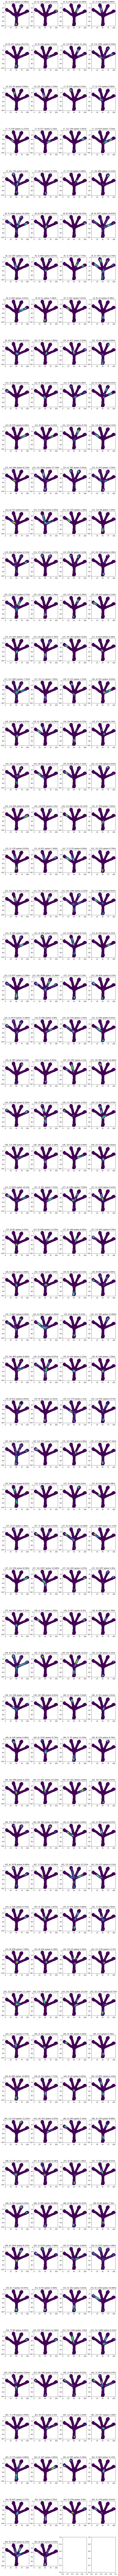

In [122]:
cells = list(spike_count_by_arm_direction.keys())
fig_row_num = int(np.ceil(len(cells)/4))
fig, axes = plt.subplots(fig_row_num, 4, figsize = (13,5*fig_row_num), squeeze = True)

ind = 0
for cell in cells:
    (e,u) = cell
    placefield = smoothed_placefield[(e,u)]
    
    axes[np.unravel_index(ind, axes.shape)].imshow(placefield)

    # peak location
    max_ind = np.unravel_index(np.nanargmax(placefield),placefield.shape)
    xbins = np.arange(placefield.shape[1])
    ybins = np.arange(placefield.shape[0])
    max_location_2D = (xbins[max_ind[1]],ybins[max_ind[0]])
    axes[np.unravel_index(ind, axes.shape)].scatter(max_location_2D[0],max_location_2D[1],marker='+',color = "C1")
    
    axes[np.unravel_index(ind, axes.shape)].set_title(str((e,u))+" "+str(
                int(np.nansum(spike_count_by_arm_direction[(e,u)])))+" spikes "+str(np.round(np.nanmax(placefield),2))+"Hz")
    #axes[np.unravel_index(ind, axes.shape)].text(200,-10,round(peak_frs[(e,u)],1))
    ind = ind + 1

animal = nwb_copy_file_name[:5]
output_folder = f'/cumulus/shijie/recording_pilot/{animal}/changeOfMind'
filename = animal+'_'+nwb_copy_file_name+'_'+session_name+'_placefields'
if len(output_folder)>0:
    plt.savefig(os.path.join(output_folder,filename+'.pdf'),format="pdf",bbox_inches='tight',dpi=200)

### 4. detailed look into specific example for sorted data

In [507]:
print('currently investigating:')
print(nwb_copy_file_name)
print(session_name)
print(position_name)
animal = nwb_copy_file_name[:5]

linear_position_info=(IntervalLinearizedPosition() & {
        'nwb_file_name':nwb_copy_file_name,
        'interval_list_name':position_name,
        'position_info_param_name':'default_decoding'}).fetch1_dataframe()

position_info = (IntervalPositionInfo() & {
        'nwb_file_name':nwb_copy_file_name,
        'interval_list_name':position_name,
        'position_info_param_name':'default_decoding'}).fetch1_dataframe()

#camera_frequency = 1/stats.mode(np.diff(linear_position_info.index))[0]

[11:23:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
haydn20230604_.nwb
04_Rev3Session2
pos 3 valid times


In [508]:
# 2. load stateScript
key={'nwb_file_name':nwb_copy_file_name,'epoch':int(session_name[:2])}
log=(TrialChoice & key).fetch1('choice_reward')
log_df=pd.DataFrame(log)
    
rowID, trials, proportions, turnaround_times = find_trials(log_df,
                                                            linear_position_info, position_info, proportion_threshold = 0.05)

In [509]:
# 3. load decode
animal = nwb_copy_file_name[:5]
decode_options = {}
if animal.lower() == "eliot":
    decode_options["encoding_set"] = '2Dheadspeed_above_4_andlowmua'
    decode_options["classifier_param_name"] = 'default_decoding_gpu_4armMaze'
    decode_options["decode_threshold_method"] = 'MUA_0SD'
    decode_options["causal"] = False
else:
    decode_options["encoding_set"] = '2Dheadspeed_above_4'
    decode_options["classifier_param_name"] = 'default_decoding_gpu_4armMaze'
    decode_options["decode_threshold_method"] = 'MUA_M05SD'
    decode_options["causal"] = False
        
decode = load_decode(nwb_copy_file_name,session_name,
                     decode_options["classifier_param_name"],decode_options["encoding_set"])

In [510]:
curation_id = -1

In [511]:
from spyglass.shijiegu.singleUnit_sortedDecode import place_field_direction, color_cells_by_place_direction

(cells, smoothed_placefield, placefield_peak,
        spike_count_by_arm_direction, time_spent_by_arm_direction, betaPdfs, means) = place_field_direction(nwb_copy_file_name,
                                                                                session_name,position_name,
                                                                                curation_id = curation_id)

In [512]:
cell_color = color_cells_by_place_direction(cells, placefield_peak, spike_count_by_arm_direction)

[11:24:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [513]:
CCTetrodeInd = (TetrodeNumber() & {'nwb_file_name': nwb_copy_file_name,
                                        'epoch_name':session_name}).fetch1('cc_tetrode_ind')
theta_data,theta_timestamps=load_theta(nwb_copy_file_name,session_name)
theta_df = pd.DataFrame(data=theta_data[:,CCTetrodeInd], index=theta_timestamps)
theta_df.index.name='time'
theta_df=xr.Dataset.from_dataframe(theta_df)

In [515]:
# 4. load theta
#CCTetrodeInd = (TetrodeNumber() & {'nwb_file_name': nwb_copy_file_name,
#                                        'epoch_name':session_name}).fetch1('cc_tetrode_ind')
#theta_data,theta_timestamps=load_theta(nwb_copy_file_name,session_name)
#theta_df = pd.DataFrame(data=theta_data[:,CCTetrodeInd], index=theta_timestamps)
#theta_df.index.name='time'
#theta_df=xr.Dataset.from_dataframe(theta_df)
from spyglass.shijiegu.theta import return_skaggs_theta
sort_group_ids = np.unique((Curation() & {'nwb_file_name': nwb_copy_file_name,
                                              "curation_id":1}).fetch("sort_group_id"))

nwb_units_all = get_nwb_units(
            nwb_copy_file_name,session_name,sort_group_ids,curation_id = curation_id)

DataJointError: fetch1 should only return one tuple. 0 tuples found

In [ ]:
#theta_df, pos1d, pos2d = return_skaggs_theta(nwb_copy_file_name,position_name,session_name,
#                                             nwb_units_all,cells)
#theta_df.index.name='time'
#theta_df=xr.Dataset.from_dataframe(theta_df)

In [ ]:
import matplotlib.patheffects as PathEffects

In [ ]:
rowID

#### specify trial ID

In [516]:
t = 6
time_minus = 5
time_plus = 2

In [475]:
if np.isin(t,rowID):
    #curation_id = 1
    plottimes = findPlottingStartEnd(t,log_df,linear_position_info)
    turnaround_t = findTurnAround_t(t,rowID, turnaround_times)
    arm_direction_t, arm_direction, _ = findDirectionPlot(t,log_df,linear_position_info,position_info)
    head_direction_sign = pd.Series(arm_direction, index = arm_direction_t)
    plottimes = (turnaround_t[0][1] - time_minus,turnaround_t[0][1] + time_plus)
else:
    plottimes = (log_df.loc[t].timestamp_H+2,log_df.loc[t].timestamp_O+0.5)

In [517]:
plottimes = (log_df.loc[t].timestamp_H,log_df.loc[t].timestamp_O )

In [518]:
results_subset = select_subset_helper(decode,plottimes)
posterior_position_subset=results_subset.causal_posterior.sum(
        dim='state')
theta_subset = select_subset_helper(theta_df,plottimes) 

linear_position_xr=xr.Dataset.from_dataframe(linear_position_info)
linear_position_subset= select_subset_helper(linear_position_xr,plottimes)

position_xr=xr.Dataset.from_dataframe(position_info)
position_subset= select_subset_helper(position_xr,plottimes)

In [519]:
cells_fired = []
for cell in cells:
    (e,u) = cell
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,e,curation_id = curation_id)
    spike_times = nwb_units.loc[u].spike_times
    spike_times = spike_times[np.logical_and(spike_times >= plottimes[0],spike_times <= plottimes[1])]
    if len(spike_times) > 0:
        cells_fired.append(cell)

In [485]:
#cells_fired

In [486]:
log_df.loc[t].timestamp_H + 30

1666811844.0125046

In [501]:
position_subset = select_subset_helper(position_xr,(1666811822.0341578, 1666811822.1581578))

In [503]:
position_subset.head_speed

<xarray.DataArray 'head_speed' (time: 63)>
array([4.10165434, 4.17123203, 4.24118487, 4.3114738 , 4.3820611 ,
       4.45291031, 4.52398611, 4.59525419, 4.66668122, 4.73823472,
       4.80988298, 4.88159505, 4.9533406 , 5.0250899 , 5.09681375,
       5.16848341, 5.24007057, 5.31154727, 5.38288584, 5.45405888,
       5.52503916, 5.59579957, 5.66631309, 5.73655272, 5.80649137,
       5.87610188, 5.94535688, 6.01422876, 6.0826896 , 6.1507111 ,
       6.21826447, 6.28532042, 6.35184906, 6.41781981, 6.48320134,
       6.54796151, 6.61206728, 6.67548464, 6.73817855, 6.80011288,
       6.86125031, 6.92155234, 6.98097914, 7.03948958, 7.09704115,
       7.1535899 , 7.20909044, 7.2634959 , 7.31675789, 7.36882651,
       7.41965032, 7.46917637, 7.51735018, 7.56411577, 7.60941571,
       7.65319111, 7.6953817 , 7.73592587, 7.77476077, 7.81182231,
       7.84704531, 7.88036357, 7.91170996])
Coordinates:
  * time     (time) float64 1.667e+09 1.667e+09 ... 1.667e+09 1.667e+09

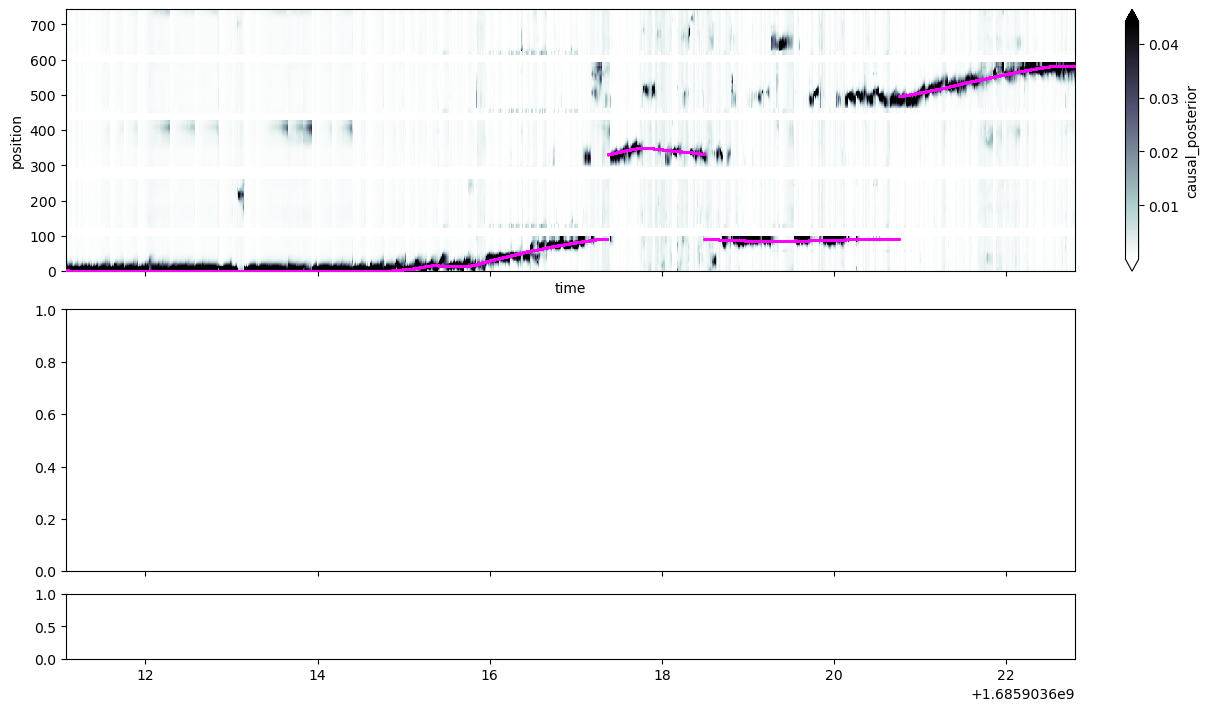

In [521]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True,
                             constrained_layout=True,gridspec_kw={"height_ratios": [2,2,0.5]})
posterior_position_subset.plot(x='time', y='position', ax=axes[0], rasterized=True, robust=True, cmap='bone_r')

#axes[0].axvspan(1666811822.0341578,1666811822.1581578, color = "blue", alpha = 0.1)

axes[0].scatter(linear_position_subset.time,
                np.array(linear_position_subset.linear_position),
                s=1, color='magenta', zorder=10)


KeyError: "No variable named 1. Variables on the dataset include ['time', 0]"

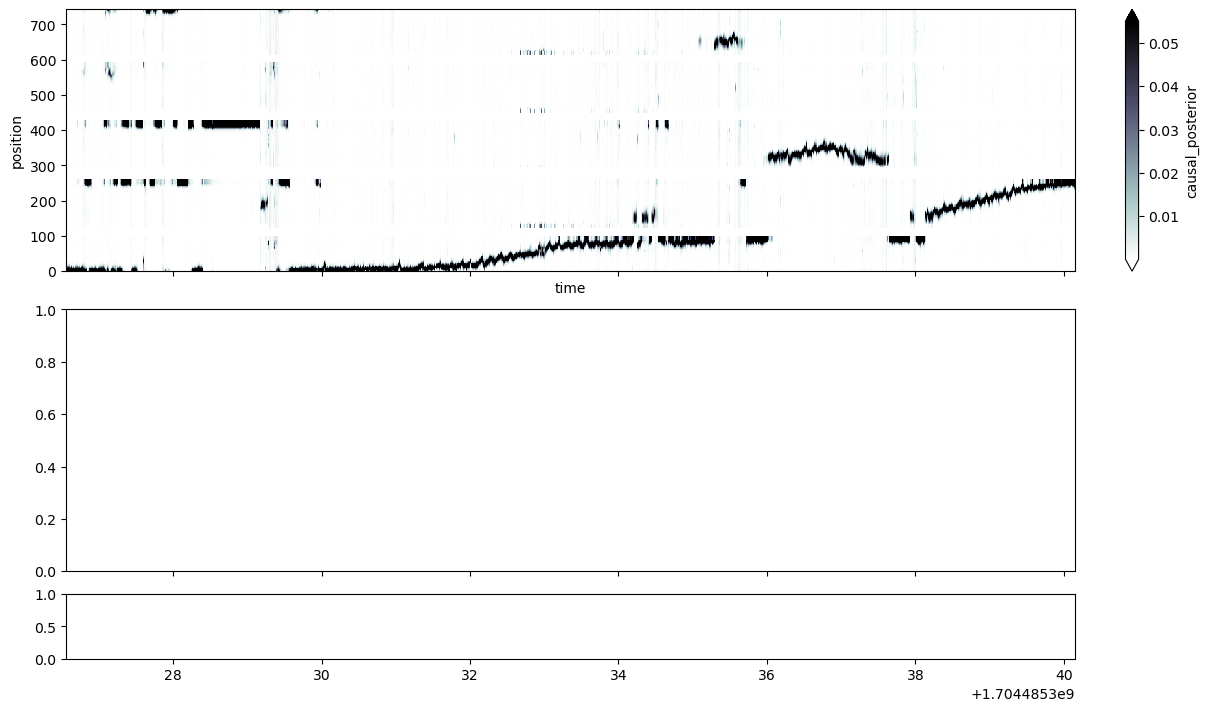

In [383]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True,
                             constrained_layout=True,gridspec_kw={"height_ratios": [2,2,0.5]})
posterior_position_subset.plot(x='time', y='position', ax=axes[0], rasterized=True, robust=True, cmap='bone_r')
for cell in cells_fired:
    e = cell[0]
    u = cell[1]
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,e,curation_id = curation_id)

    spike_times = nwb_units.loc[u].spike_times
    spike_times = spike_times[np.logical_and(spike_times >= plottimes[0],spike_times <= plottimes[1])]

    if cell_color[(e,u)] == "k":
        cell_color[(e,u)] = "C2"

    axes[1].scatter(spike_times, np.zeros(len(spike_times)) + placefield_peak[(e,u)],
                    rasterized=True, marker='|', color = cell_color[(e,u)],alpha = 0.5)
    #if len(spike_times) > 0:
        #txt = axes[1].text(spike_times[0],placefield_peak[(e,u)],str((e,u)),rotation = 10, color = cell_color[(e,u)])
        #txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w',alpha = 0.8)])


theta_d0=np.array(np.array(theta_subset[0])).astype('int32').T
theta_d1=np.array(np.array(theta_subset[1])).astype('int32').T
theta_t=np.array(theta_subset.time)
axes[2].plot(theta_t,theta_d0)
axes[2].plot(theta_t,theta_d1)
axes[2].set_title('theta LFP')



axes[0].scatter(linear_position_subset.time,
                np.array(linear_position_subset.linear_position),
                s=1, color='magenta', zorder=10)

axes[1].scatter(linear_position_subset.time,
                np.array(linear_position_subset.linear_position),
                s=1, color='magenta', zorder=10)
for turnaround_time in turnaround_t:
    axes[0].axvspan(turnaround_time[0], turnaround_time[1], color = "red", alpha = 0.1)

#axes[0].axvspan(1704838917.2877982, 1704838917.3237982, color = "blue", alpha = 0.1)

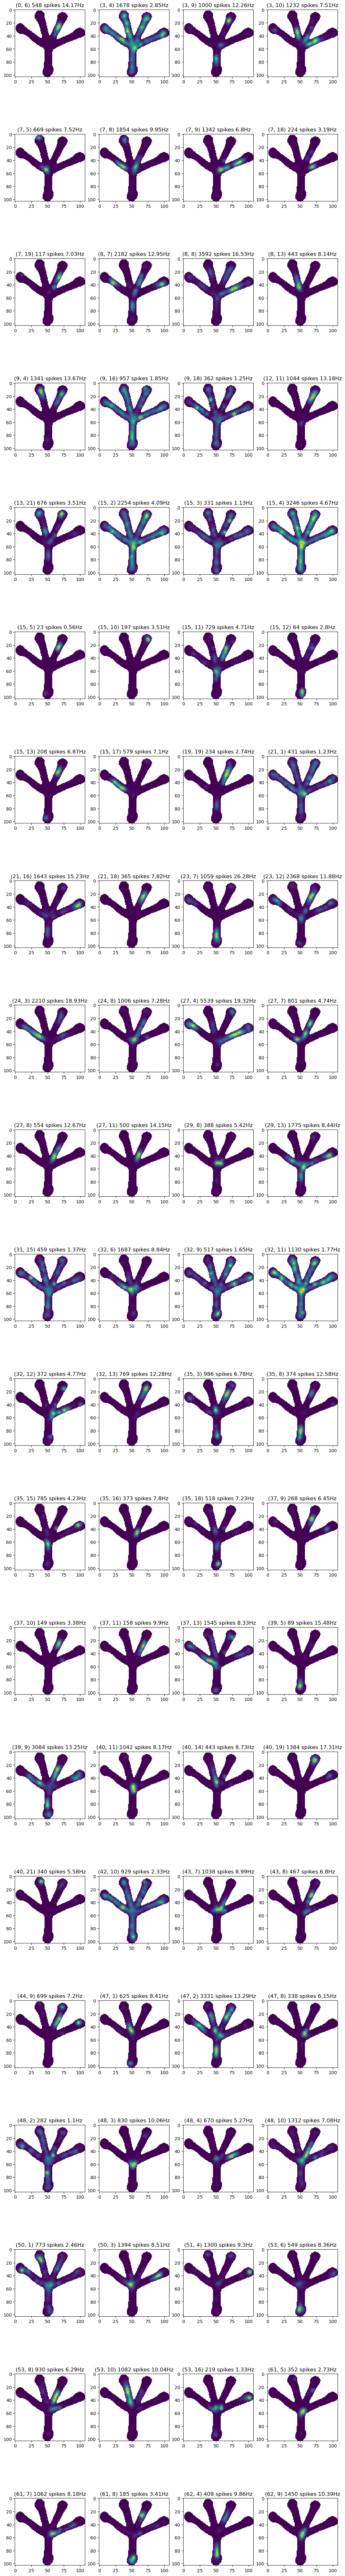

In [185]:
cells_ = cells_fired
fig_row_num = int(np.ceil(len(cells_)/4))
fig, axes = plt.subplots(fig_row_num, 4, figsize = (13,5*fig_row_num), squeeze = True)

ind = 0
for cell in cells_:
    (e,u) = cell
    placefield = smoothed_placefield[(e,u)]
    
    axes[np.unravel_index(ind, axes.shape)].imshow(placefield)

    # peak location
    max_ind = np.unravel_index(np.nanargmax(placefield),placefield.shape)
    xbins = np.arange(placefield.shape[1])
    ybins = np.arange(placefield.shape[0])
    max_location_2D = (xbins[max_ind[1]],ybins[max_ind[0]])
    axes[np.unravel_index(ind, axes.shape)].scatter(max_location_2D[0],max_location_2D[1],marker='+',color = "C1")
    
    axes[np.unravel_index(ind, axes.shape)].set_title(str((e,u))+" "+str(
                int(np.nansum(spike_count_by_arm_direction[(e,u)])))+" spikes "+str(np.round(np.nanmax(placefield),2))+"Hz")
    #axes[np.unravel_index(ind, axes.shape)].text(200,-10,round(peak_frs[(e,u)],1))
    ind = ind + 1
